<a href="https://colab.research.google.com/github/RCortez25/PhD/blob/main/LLM/7.%20Feed%20forward/Feed_forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

# GELU (Gaussian Error Linear Unit)

$$x\Phi(x)$$

where $\Phi(x)$ is the CDF of a standard Gaussian distribution. The approximation used for training GPT2 was

$$GELU(x)=0.5x(1+\tanh\left[\sqrt{(2/\pi)}(x+0.044715x^3)\right])$$

GELU allows for small non-zero output for negative values. This means that neurons that receive negative inputs still contribute to the learning process.

In [6]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        result = 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))
        return result

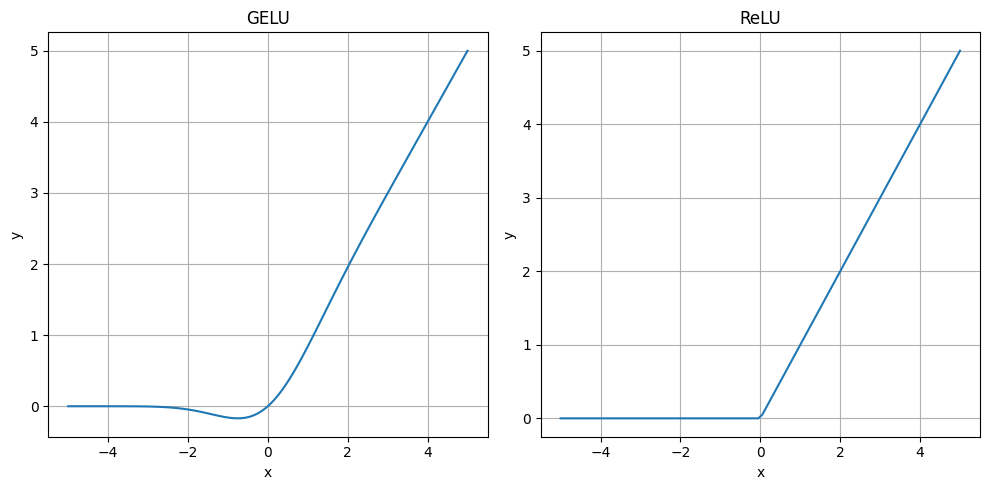

In [8]:
import matplotlib.pyplot as plt

class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(torch.tensor(0.0), x)

gelu, relu = GELU(), ReLU()

x = torch.linspace(-5, 5, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(10, 5))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(x, y)
    plt.title(label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Feed forward block

The stucture of this block is as follows:

Linear layer 1 --> GELU --> Linear layer 2

In this block, the inputs are mapped to into a 4-times larger space vis a first linear layer, then GELU is applied to the data, and finally, the second linear layer maps the data back into the original dimension, that is, 4-times smaller than the GELU output.

For the configuration we are using, the inputs are in a 768-dimensional space, then they get mapped to a 4*768 dimensional space, GELU is applied, then they're are mapped back to the 768-dimensional space, so that data can continue its journey through the GPT model.

This can be called **expansion** and **contraction**. One can say that they allow for a richer exploration space.

In [9]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["embedding_dimension"], 4 * config["embedding_dimension"]), # Expansion
            GELU(), # Activation
            nn.Linear(4 * config["embedding_dimension"], config["embedding_dimension"]) # Contraction
        )

    def forward(self, x):
        return self.layers(x)

# Example

In [10]:
# Configuration for our GPT model
GPT_CONFIG_124M = {
    "vocab_size": 50257,        # Number of words/sub-words
    "context_length": 1024,     # How many words used to predict the next word
    "embedding_dimension": 768, # Tokens are projected into a 768-dimensional space
    "number_of_heads": 12,      # This creates 12 query, key, and value matrices
    "number_of_layers": 12,     # Number of transformer blocks
    "dropout_rate": 0.1,
    "qkv_bias": False}

In [13]:
oFeedForward = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 3, 768)
output = oFeedForward(x)
print(output.shape)

torch.Size([2, 3, 768])
